# EMANUELE BELLINI

## Packages

In [26]:
!pip install seaborn

In [27]:
import networkx as nx # For graphs
import pickle # For data parsing
import networkx as nx
from networkx.algorithms.approximation import greedy_tsp # For approx TSP
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns

## Helper functions

In [6]:

def tour_length(G, tour):
    """
    Compute the length of a tour. A tour is a list having elements 0 and -1 equal
    """
    assert tour[0] == tour[-1], "Not valid tour"
    estimated = 0
    # Bug: using undeclared 'n' instead of len(tour)-1
    for i in range(len(tour) - 1): 
        estimated += G[tour[i]][tour[i + 1]]['weight']
    return estimated

def greedy_algorithm(G):
    """
    Run the value of the greedy approximation algorithm on graph G
    """
    return tour_length(G, greedy_tsp(G, weight='weight'))

def random_tour(G, seed = 42):
    """
    Return the value of a random tour
    """
    np.random.seed(seed)
    n = G.number_of_nodes()
    tour = [0]
    for i in range(1, n):
        next_node = np.random.choice([j for j in range(n) if j not in tour])
        tour.append(next_node)
    tour.append(0)
    return tour_length(G, tour)  # Added return statement

def transformer_tsp(G, model, DEVICE = 'cpu'):
    """
    Evaluate your (trained) model on G
    """
    # Set the model in evaluation mode
    model.eval()

    # Note: number of edges is constant ed equal to n(n-1)/2
    n = G.number_of_nodes()
    
    # Get node coordinates
    attr = nx.get_node_attributes(G, 'pos')
    x = []
    for i in range(n):
        x.append(torch.tensor(attr[i], dtype=torch.float32))

    # From list of tensors to tensor 2d
    x = torch.stack(x)    

    tour = [0]
    y = torch.tensor(tour, dtype=torch.long)
    x = x.to(DEVICE).unsqueeze(0)
    y = y.to(DEVICE).unsqueeze(0)
    
    # Predict the next node
    out = model(x, y)
    
    while len(tour) < n:
        _, idx = torch.topk(out, n, dim=2)
        for i in range(n):
            if idx[0, 0, i] not in tour:
                tour.append(idx[0, 0, i])
                break
        y = torch.tensor(tour)
        y = y.to(DEVICE).unsqueeze(0)
        out = model(x, y)  # Change here too
    
    tour = [int(i) for i in tour] + [0]
    return tour_length(G, tour)



def gap(G, model = None, model_GA = None, random_seed = 42, device = 'cpu'):
    """
    Compute the gap between the optimal solution on graph G and all the analyzed methods
    """

        
    # Optimal value (hard-coded in the graph)
    TSP = sum([G[i][j]['weight']*G[i][j]['tour'] for (i, j) in G.edges()]) # Optimal

    # Gaps dictionary
    gaps = {'greedy' : 0, 'random' : 0, 'transformer_tsp': 0, 'transformer_tsp_acc_grad': 0}
    gaps['greedy'] = 100* (greedy_algorithm(G) -  TSP) / TSP
    gaps['random'] = 100 * (random_tour(G, random_seed) - TSP) / TSP
    if model is not None:
        gaps['transformer_tsp'] = 100 * (transformer_tsp(G, model, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp'] = float('inf') # In case you just train with GA
        
    if model_GA is not None:
        gaps['transformer_tsp_acc_grad'] = 100 * (transformer_tsp(G, model_GA, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp_acc_grad'] = float('inf') # In case you just train without GA
    return gaps    
    

## Dataset & Dataloader

In [7]:
class TSPDataset(Dataset):
    """
    Dataset class for TSP problem. 
    Each instance consists of a tuple (G, tour) where:
    - G is a NetworkX graph with node coordinates and edge weights
    - tour is a list representing the optimal tour
    """
    def __init__(self, filepath):
        """
        Initialize the dataset by loading the pickle file.
        
        Args:
            filepath (str): Path to the pickle file containing the data
        """
        with open(filepath, 'rb') as f:
            self.data = pickle.load(f)
            
    def __len__(self):
        """Return the number of instances in the dataset"""
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Get a single TSP instance.
        
        Args:
            idx (int): Index of the instance to return
                
        Returns:
            tuple: (node_coords, tour) where:
                - node_coords: tensor of shape (num_nodes, 2) containing x,y coordinates
                - tour: tensor of shape (num_nodes + 1) representing optimal tour,
                starting and ending with 0
                
        Raises:
            IndexError: If idx is out of range
            ValueError: If graph doesn't have exactly 20 nodes or if tour is invalid
        """
        # Validate index
        if idx < 0 or idx >= len(self.data):
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self.data)}")
            
        # Unpack the tuple containing (graph, tour)
        G, optimal_tour = self.data[idx]
        
        # Validate graph size
        num_nodes = G.number_of_nodes()
        if num_nodes != 20:
            raise ValueError(f"Expected graph with 20 nodes, got {num_nodes} nodes")
        
        # Extract node coordinates
        node_coords = torch.zeros((num_nodes, 2))
        for i in range(num_nodes):
            node_coords[i] = torch.tensor(G.nodes[i]['pos'])
                
        # Validate and process tour
        if len(set(optimal_tour)) != num_nodes:
            raise ValueError("Tour must visit each node exactly once")
            
        # Ensure tour starts and ends with 0
        if optimal_tour[0] != 0:
            optimal_tour = optimal_tour[optimal_tour.index(0):] + optimal_tour[:optimal_tour.index(0)]
        if optimal_tour[-1] != 0:
            optimal_tour.append(0)
                
        return node_coords, torch.tensor(optimal_tour)

In [8]:
def create_dataloaders(train_path, val_path, test_path, batch_size=32):
    """
    Create DataLoader objects for training, validation and testing.
    
    Args:
        train_path (str): Path to training data pickle file
        val_path (str): Path to validation data pickle file 
        test_path (str): Path to test data pickle file
        batch_size (int): Batch size for the dataloaders
        
    Returns:
        tuple: (train_loader, val_loader, test_loader)
        
    Raises:
        FileNotFoundError: If any of the data files don't exist
        ValueError: If batch_size is invalid
    """
    # Validate inputs
    if batch_size <= 0:
        raise ValueError(f"Batch size must be positive, got {batch_size}")
        
    for path in [train_path, val_path, test_path]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Data file not found: {path}")
    
    # Create datasets
    train_dataset = TSPDataset(train_path)
    val_dataset = TSPDataset(val_path)
    test_dataset = TSPDataset(test_path)
    
    # Verify dataset sizes are appropriate
    if len(train_dataset) == 0:
        raise ValueError("Training dataset is empty")
    
    # Create dataloaders with appropriate settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

In [9]:
print("Part 1: Raw Data Exploration")
print("-" * 50)

# First, examine the raw data structure
with open('data/dummy_20_DLL_ass4.pkl', 'rb') as f:
    raw_data = pickle.load(f)

print("Raw data type:", type(raw_data))
print("Dataset size:", len(raw_data))

if len(raw_data) > 0:
    first_item = raw_data[0]
    print("\nStructure of a single instance:")
    print(f"Type: {type(first_item)}")
    print(f"Number of elements: {len(first_item)}")
    
    # Examine graph structure
    G, tour = first_item
    print("\nGraph properties:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Example node position: {G.nodes[0]['pos']}")
    edge = list(G.edges(data=True))[0]
    print(f"Example edge ({edge[0]}-{edge[1]}):")
    print(f"  Weight: {edge[2]['weight']}")
    print(f"  Tour: {edge[2]['tour']}")

print("\nPart 2: Dataset Implementation Verification")
print("-" * 50)

# Now test our dataset implementation
dummy_dataset = TSPDataset("data/dummy_20_DLL_ass4.pkl")
print("Dataset loaded successfully!")

# Verify data transformation
coords, tour = dummy_dataset[0]
print("\nProcessed data formats:")
print(f"Coordinate tensor shape: {coords.shape}")
print(f"First node coordinates: {coords[0]}")
print(f"Tour tensor shape: {tour.shape}")
print(f"Complete tour: {tour}")

# Verify transformation correctness by comparing with raw data
print("\nVerification against raw data:")
raw_coords = torch.tensor(list(raw_data[0][0].nodes[0]['pos']))
print(f"Original coordinates: {raw_coords}")
print(f"Transformed coordinates: {coords[0]}")
assert torch.allclose(raw_coords, coords[0]), "Coordinate transformation mismatch!"

print("\nAll verifications passed successfully!")

Part 1: Raw Data Exploration
--------------------------------------------------
Raw data type: <class 'list'>
Dataset size: 100

Structure of a single instance:
Type: <class 'tuple'>
Number of elements: 2

Graph properties:
Number of nodes: 20
Example node position: (0.6049077053425551, 0.5748590937018008)
Example edge (0-1):
  Weight: 0.4287846201876535
  Tour: 0

Part 2: Dataset Implementation Verification
--------------------------------------------------
Dataset loaded successfully!

Processed data formats:
Coordinate tensor shape: torch.Size([20, 2])
First node coordinates: tensor([0.6049, 0.5749])
Tour tensor shape: torch.Size([21])
Complete tour: tensor([ 0,  3, 14,  2,  9,  6, 19, 13, 12, 16,  7, 18,  8, 17,  5, 11, 10, 15,
         1,  4,  0])

Verification against raw data:
Original coordinates: tensor([0.6049, 0.5749])
Transformed coordinates: tensor([0.6049, 0.5749])

All verifications passed successfully!


## Model

In [10]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding for the decoder sequence.
    This is essential for the decoder to understand the order of nodes in the partial tour.
    """
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        """Add positional encoding to the input."""
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [11]:
class TSPTransformer(nn.Module):
    """
    Transformer model for solving TSP.
    Takes node coordinates as input and predicts the next node in the tour.
    """
    def __init__(
        self,
        d_model=128,
        nhead=8,
        num_encoder_layers=6,
        num_decoder_layers=6,
        dim_feedforward=512,
        dropout=0.1
    ):
        super(TSPTransformer, self).__init__()
        
        # Initial linear projection for node coordinates
        self.coord_embedding = nn.Linear(2, d_model)
        
        # Node embedding for decoder input
        self.node_embedding = nn.Embedding(21, d_model)  # 20 nodes + 1 for padding
        
        # Positional encoding (only for decoder)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Create transformer components
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        self.decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_decoder_layers
        )
        
        # Output projection
        self.out_proj = nn.Linear(d_model, 21)  # Project to node probabilities
        
        # Initialize parameters
        self._reset_parameters()
        
    def _reset_parameters(self):
        """Initialize model parameters."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def generate_square_subsequent_mask(self, sz):
        """Generate causal mask for decoder."""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt):
        """
        Forward pass through the model.
        Args:
            src: Node coordinates (batch_size, num_nodes, 2)
            tgt: Partial tour sequence (batch_size, current_length)
        """
        # Create causal mask for decoder
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        
        # Embed inputs
        src = self.coord_embedding(src)  # Embed coordinates
        tgt = self.node_embedding(tgt)   # Embed node indices
        
        # Add positional encoding to decoder input
        tgt = self.pos_encoder(tgt)
        
        # Run through encoder
        memory = self.encoder(src)
        
        # Run through decoder with causal mask
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        
        # Project to node probabilities
        return self.out_proj(output)

In [12]:
class TSPModel:
    """Helper class to manage training and inference."""
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
    
    def predict_tour(self, coords):
        """
        Predict a tour for given coordinates.
        Compatible with transformer_tsp function from helper.
        """
        self.model.eval()
        with torch.no_grad():
            tour = [0]  # Start from node 0
            x = coords.unsqueeze(0)  # Add batch dimension
            
            while len(tour) < coords.size(0):
                y = torch.tensor([tour], device=self.device)
                out = self.model(x, y)
                
                # Get probabilities for next node
                probs = out[:, -1].softmax(dim=-1)
                
                # Mask visited nodes
                mask = self.model.create_mask(tour, self.device)
                probs = probs * mask
                
                # Select next node
                next_node = probs.argmax().item()
                tour.append(next_node)
            
            tour.append(0)  # Complete the tour
            return torch.tensor(tour)

## Training

### Training WITHOUT gradient accumulation

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    
    Args:
        model: The transformer model
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer for updating weights
        device: Device to train on
        
    Returns:
        float: Average loss for this epoch
    """
    model.train()
    total_loss = 0
    num_batches = 0
    
    # Use tqdm for progress bar
    for coords, tours in tqdm(train_loader, desc="Training"):
        # Move data to device
        coords = coords.to(device)
        tours = tours.to(device)
        
        # Create input sequence (all nodes except last)
        src = coords
        tgt = tours[:, :-1]  # Remove last node (0) from tour
        
        # Create target sequence (all nodes except first)
        target = tours[:, 1:]  # Shift tours by 1 position
        
        # Forward pass
        output = model(src, tgt)
        
        # Reshape output and target for loss computation
        batch_size, seq_len, vocab_size = output.shape
        output = output.reshape(-1, vocab_size)
        target = target.reshape(-1)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        # Optional gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

In [14]:
def validate(model, val_loader, criterion, device):
    """
    Validate the model.
    
    Args:
        model: The transformer model
        val_loader: DataLoader for validation data
        criterion: Loss function
        device: Device to validate on
        
    Returns:
        float: Average validation loss
    """
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for coords, tours in val_loader:
            coords = coords.to(device)
            tours = tours.to(device)
            
            # Same sequence processing as training
            src = coords
            tgt = tours[:, :-1]
            target = tours[:, 1:]
            
            output = model(src, tgt)
            
            # Reshape and compute loss
            output = output.reshape(-1, output.size(-1))
            target = target.reshape(-1)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

In [18]:
def train_model(model, train_loader, val_loader, device, 
                max_minutes=10, log_every=1, save_path='tsp_model.pth'):
    """
    Train the model with early stopping based on validation loss.
    
    Args:
        model: The transformer model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        device: Device to train on
        max_minutes: Maximum training time in minutes
        log_every: How often to log losses
        save_path: Where to save best model
        
    Returns:
        list, list: Training and validation losses
    """
    # Initialize training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    # For tracking progress
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    start_time = time.time()
    epoch = 0
    
    while (time.time() - start_time) < max_minutes * 60:
        epoch += 1
        
        # Train for one epoch
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save progress
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
        
        # Log progress
        if epoch % log_every == 0:
            elapsed = (time.time() - start_time) / 60
            print(f"Epoch {epoch} ({elapsed:.1f}min)")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print("Current LR:", optimizer.param_groups[0]['lr'])
            print("-" * 40)
            
        # Early stopping check
        if optimizer.param_groups[0]['lr'] < 1e-6:
            print("Learning rate too small, stopping training")
            break
    
    return train_losses, val_losses

In [16]:
def plot_training_progress(train_losses, val_losses):
    """
    Plot training and validation losses.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

Using device: cuda


Training: 100%|██████████| 1563/1563 [00:42<00:00, 36.70it/s]


Epoch 10 (7.2min)
Train Loss: 2.0017
Val Loss: 1.9831
Current LR: 0.0001
----------------------------------------


Training: 100%|██████████| 1563/1563 [00:42<00:00, 36.67it/s]


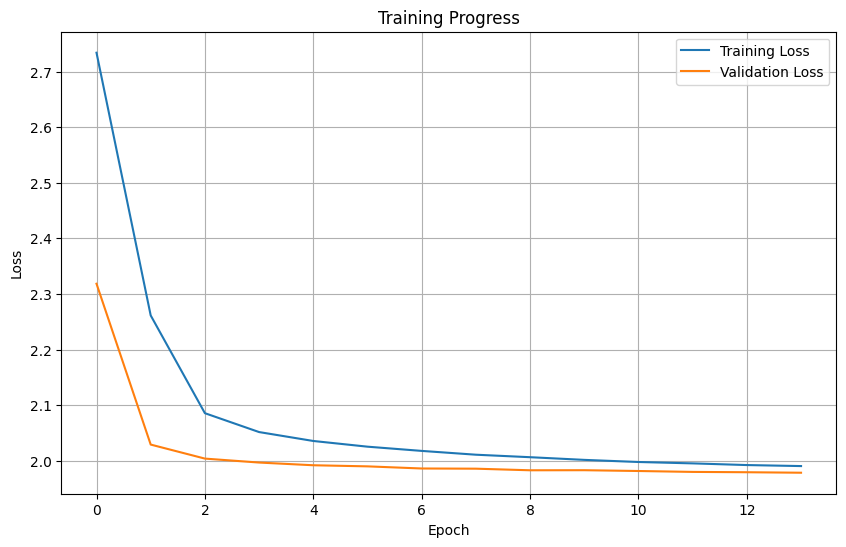

In [17]:
# Assuming we have our model and dataloaders ready
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = TSPTransformer().to(device)

train_loader, val_loader, test_loader = create_dataloaders(
    'data/train_20_DLL_ass4.pkl',
    'data/valid_20_DLL_ass4.pkl',
    'data/test_20_DLL_ass4.pkl',
    batch_size=32
)

# Train the model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

# Plot training progress
plot_training_progress(train_losses, val_losses)

### Training WITH gradient accumulation

In [19]:
def train_epoch_with_accumulation(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    """
    Train for one epoch using gradient accumulation.
    
    Args:
        model: The transformer model
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer for updating weights
        device: Device to train on
        accumulation_steps: Number of steps to accumulate gradients over
        
    Returns:
        float: Average loss for this epoch
    """
    model.train()
    total_loss = 0
    num_batches = 0
    optimizer.zero_grad()  # Zero gradients at start of epoch
    
    for batch_idx, (coords, tours) in enumerate(tqdm(train_loader, desc="Training")):
        # Move data to device
        coords = coords.to(device)
        tours = tours.to(device)
        
        # Same sequence processing as standard training
        src = coords
        tgt = tours[:, :-1]  # Remove last node (0) from tour
        target = tours[:, 1:]  # Shift tours by 1 position
        
        # Forward pass
        output = model(src, tgt)
        
        # Compute loss and normalize by accumulation steps
        batch_size, seq_len, vocab_size = output.shape
        output = output.reshape(-1, vocab_size)
        target = target.reshape(-1)
        loss = criterion(output, target) / accumulation_steps
        
        # Backward pass (accumulate gradients)
        loss.backward()
        
        # Update weights only after accumulating gradients
        if (batch_idx + 1) % accumulation_steps == 0:
            # Gradient clipping based on accumulated gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        # Track loss (store the unnormalized loss)
        total_loss += loss.item() * accumulation_steps
        num_batches += 1
    
    # Handle any remaining gradients at the end of epoch
    if num_batches % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    return total_loss / num_batches

In [20]:
def train_model_with_accumulation(model, train_loader, val_loader, device, 
                                accumulation_steps=4, max_minutes=10, 
                                log_every=10, save_path='tsp_model_ga.pth'):
    """
    Train the model using gradient accumulation.
    Reuses most of the standard training logic but with accumulated gradients.
    """
    # Initialize training with same hyperparameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    # For tracking progress
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    start_time = time.time()
    epoch = 0
    
    # Effective batch size = batch_size * accumulation_steps
    print(f"Effective batch size: {train_loader.batch_size * accumulation_steps}")
    
    while (time.time() - start_time) < max_minutes * 60:
        epoch += 1
        
        # Train with gradient accumulation
        train_loss = train_epoch_with_accumulation(
            model, train_loader, criterion, optimizer, device, accumulation_steps
        )
        
        # Reuse standard validation (no need for accumulation during validation)
        val_loss = validate(model, val_loader, criterion, device)
        
        # Same tracking and logging logic as standard training
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
        
        if epoch % log_every == 0:
            elapsed = (time.time() - start_time) / 60
            print(f"Epoch {epoch} ({elapsed:.1f}min)")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print("Current LR:", optimizer.param_groups[0]['lr'])
            print("-" * 40)
        
        if optimizer.param_groups[0]['lr'] < 1e-6:
            print("Learning rate too small, stopping training")
            break
    
    return train_losses, val_losses

Effective batch size: 128


Training: 100%|██████████| 1563/1563 [00:40<00:00, 38.38it/s]


Epoch 10 (6.9min)
Train Loss: 2.0313
Val Loss: 1.9928
Current LR: 0.0001
----------------------------------------


Training: 100%|██████████| 1563/1563 [00:40<00:00, 38.73it/s]


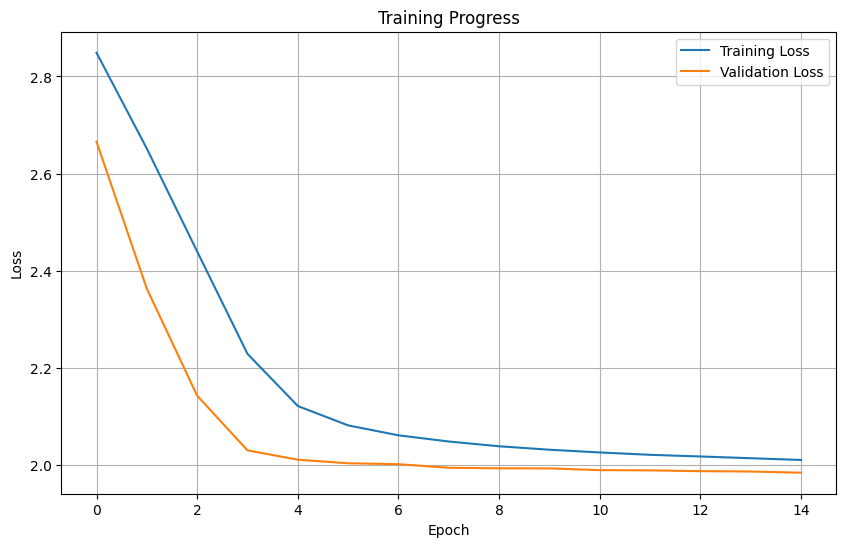

In [21]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TSPTransformer().to(device)

train_loader, val_loader, test_loader = create_dataloaders(
    'data/train_20_DLL_ass4.pkl',
    'data/valid_20_DLL_ass4.pkl',
    'data/test_20_DLL_ass4.pkl',
    batch_size=32  # This will be multiplied by accumulation_steps
)

# Train with gradient accumulation
train_losses_ga, val_losses_ga = train_model_with_accumulation(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    accumulation_steps=4  # Effectively quadruples the batch size
)

# Plot training progress
plot_training_progress(train_losses_ga, val_losses_ga)

## Testing

In [22]:
def evaluate_all_methods(test_dataset, model, model_GA=None, device='cpu', num_samples=100):
    """
    Evaluate all methods (random, greedy, and transformer) on the test dataset.
    
    Args:
        test_dataset: Dataset containing test instances
        model: Standard trained transformer model
        model_GA: Transformer model trained with gradient accumulation (optional)
        device: Device to run evaluation on
        num_samples: Number of test instances to evaluate
        
    Returns:
        list: List of dictionaries containing gaps for each method
    """
    print("Evaluating methods on test set...")
    all_gaps = []
    
    # Evaluate on specified number of test instances
    for i in tqdm(range(min(num_samples, len(test_dataset)))):
        # Get the graph from test dataset
        G = test_dataset.data[i][0]
        
        # Calculate gaps using the provided gap function
        gaps = gap(G, model=model, model_GA=model_GA, device=device)
        all_gaps.append(gaps)
    
    return all_gaps

In [23]:
def plot_gap_distributions(all_gaps):
    """
    Create boxplots showing the distribution of gaps for each method.
    """
    # Extract gaps for each method
    method_gaps = {
        'Random': [g['random'] for g in all_gaps],
        'Greedy': [g['greedy'] for g in all_gaps],
        'Transformer': [g['transformer_tsp'] for g in all_gaps],
        'Transformer (GA)': [g['transformer_tsp_acc_grad'] for g in all_gaps 
                           if g['transformer_tsp_acc_grad'] != float('inf')]
    }
    
    plt.figure(figsize=(10, 6))
    
    # Create boxplot
    sns.boxplot(data=[v for v in method_gaps.values()], 
                medianprops=dict(color="red"))
    
    # Customize plot
    plt.xticks(range(len(method_gaps)), method_gaps.keys())
    plt.ylabel('Optimality Gap (%)')
    plt.title('Distribution of Optimality Gaps by Method')
    plt.grid(True, alpha=0.3)
    
    return method_gaps

Evaluating methods on test set...


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Summary Statistics:

Random:
Mean Gap: 177.12%
Median Gap: 176.33%
Std Dev: 29.56%
Min Gap: 114.46%
Max Gap: 257.56%

Greedy:
Mean Gap: 16.63%
Median Gap: 15.72%
Std Dev: 10.68%
Min Gap: 0.00%
Max Gap: 39.81%

Transformer:
Mean Gap: 177.10%
Median Gap: 171.44%
Std Dev: 38.11%
Min Gap: 96.76%
Max Gap: 284.55%

Transformer (GA):
Mean Gap: 175.95%
Median Gap: 173.91%
Std Dev: 31.35%
Min Gap: 112.11%
Max Gap: 259.39%


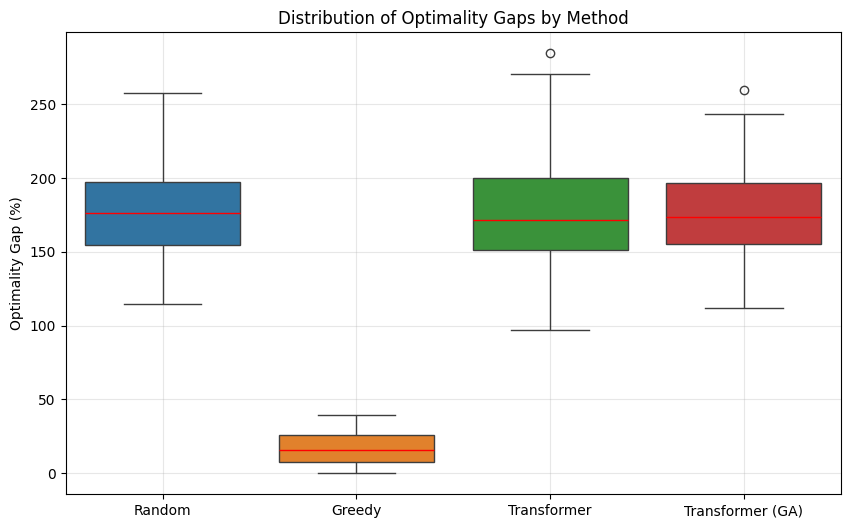

In [28]:
# Load test dataset
test_dataset = TSPDataset("data/test_20_DLL_ass4.pkl")

# Load models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load standard trained model
model = TSPTransformer().to(device)
model.load_state_dict(torch.load('tsp_model.pth'))
model.eval()

# Load GA trained model if available
try:
    model_GA = TSPTransformer().to(device)
    model_GA.load_state_dict(torch.load('tsp_model_ga.pth'))
    model_GA.eval()
except:
    model_GA = None

# Evaluate methods
all_gaps = evaluate_all_methods(test_dataset, model, model_GA, device)

# Plot distributions
method_gaps = plot_gap_distributions(all_gaps)

# Print summary statistics
print("\nSummary Statistics:")
for method, gaps in method_gaps.items():
    print(f"\n{method}:")
    print(f"Mean Gap: {np.mean(gaps):.2f}%")
    print(f"Median Gap: {np.median(gaps):.2f}%")
    print(f"Std Dev: {np.std(gaps):.2f}%")
    print(f"Min Gap: {np.min(gaps):.2f}%")
    print(f"Max Gap: {np.max(gaps):.2f}%")